In [6]:
import pytesseract
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
import torch

In [20]:
model_path = "/workspaces/Document_Layout_Understanding/models/trained/layoutlmv3-funsd-final/"  # Path to saved model
processor = LayoutLMv3Processor.from_pretrained(model_path, apply_ocr=False)
model = LayoutLMv3ForTokenClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [21]:
def extract_text_and_boxes(image_path):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    
    # Use Tesseract with optimized config
    ocr_data = pytesseract.image_to_data(
        image, 
        output_type=pytesseract.Output.DICT,
        config='--psm 6'  # Assume single uniform text block
    )
    
    words, boxes, confidences = [], [], []

    for i, text in enumerate(ocr_data['text']):
        if int(ocr_data['conf'][i]) > 60 and text.strip():
            x = ocr_data['left'][i]
            y = ocr_data['top'][i]
            w = ocr_data['width'][i]
            h = ocr_data['height'][i]
            # Normalize coordinates for LayoutLMv3 [0-1000]
            box = [
                int(1000 * (x / width)),
                int(1000 * (y / height)),
                int(1000 * ((x + w) / width)),
                int(1000 * ((y + h) / height))
            ]
            words.append(text.strip())
            boxes.append(box)
            confidences.append(float(ocr_data['conf'][i]))
    
    return words, boxes, image, confidences

In [22]:
def predict_document_layout(image_path):
    words, boxes, image, confidences = extract_text_and_boxes(image_path)
    
    encoding = processor(
        image, 
        words, 
        boxes=boxes,
        return_offsets_mapping=True,
        truncation=True,
        return_tensors="pt",
        padding="max_length",
        max_length=512
    )

    inputs = {k: v.to(device) for k, v in encoding.items()}
    offset_mapping = inputs.pop("offset_mapping").cpu().numpy()
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Process predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    
    # Aggregate subword predictions
    final_words, final_boxes, final_preds = [], [], []

    for idx, (word, box) in enumerate(zip(words, boxes)):
        if idx >= len(offset_mapping[0]):
            break
            
        # Find all tokens belonging to this word
        word_tokens = []
        start_idx = encoding.word_to_tokens(idx).start
        end_idx = encoding.word_to_tokens(idx).end
        
        if start_idx is not None:
            word_tokens = predictions[start_idx:end_idx]
            # Take most frequent prediction for the word
            pred = max(set(word_tokens), key=word_tokens.count)
            final_words.append(word)
            final_boxes.append(box)
            final_preds.append(pred)

    return final_words, final_boxes, final_preds, image

In [23]:
def visualize_predictions(image, words, boxes, predictions, id2label):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except:
        font = ImageFont.load_default()
    
    width, height = image.size
    color_map = {
        "QUESTION": "blue",
        "ANSWER": "green",
        "HEADER": "red",
        "OTHER": "purple",
        "O": "gray"
    }

    for word, box, pred in zip(words, boxes, predictions):
        # Convert normalized box to image coordinates
        x1 = int((box[0] / 1000) * width)
        y1 = int((box[1] / 1000) * height)
        x2 = int((box[2] / 1000) * width)
        y2 = int((box[3] / 1000) * height)
        
        # Draw bounding box
        label = id2label.get(pred, "O")
        draw.rectangle([x1, y1, x2, y2], outline=color_map.get(label, "black"), width=2)
        
        # Draw label background
        text = f"{label}:{word}"
        text_width = font.getlength(text)
        draw.rectangle([x1, y1-20, x1+text_width+5, y1], fill="white")
        draw.text((x1+2, y1-20), text, fill="black", font=font)

    return image

/workspaces/Document_Layout_Understanding/venv/lib/python3.12/site-packages/transformers/modeling_utils.py:1731: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


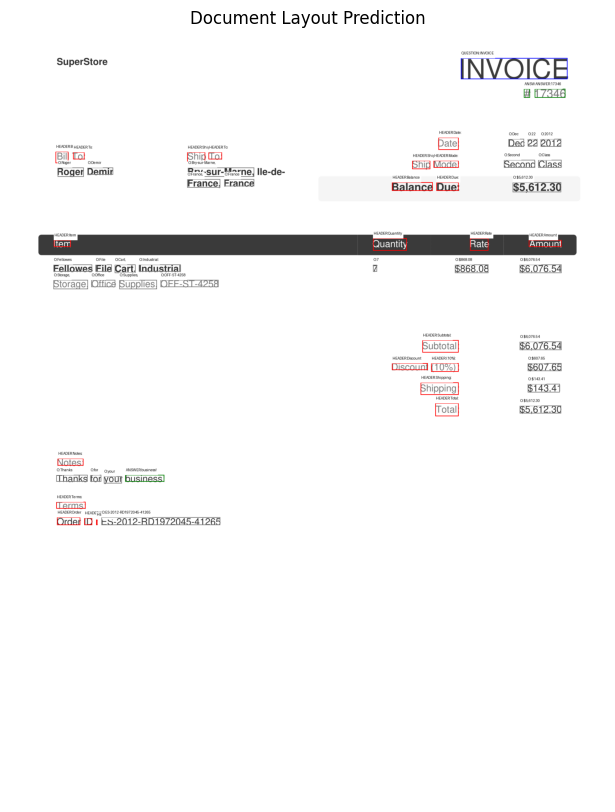


Structured Document Output:
QUESTION: [INVOICE ]
ANSWER: [# 17346 ]
HEADER: [Date: ]
O: [Dec 22 2012 ]
HEADER: [Bill To: Ship To: Ship Mode: ]
O: [Second Class Roger Demir Bry-sur-Marne, France, France ]
HEADER: [Balance Due: ]
O: [$5,612.30 ]
HEADER: [Item Quantity Rate Amount ]
O: [Fellowes File Cart, Industrial 7 $868.08 $6,076.54 Storage, Office Supplies, OFF-ST-4258 ]
HEADER: [Subtotal: ]
O: [$6,076.54 ]
HEADER: [Discount (10%): ]
O: [$607.65 ]
HEADER: [Shipping: ]
O: [$143.41 ]
HEADER: [Total: ]
O: [$5,612.30 ]
HEADER: [Notes: ]
O: [Thanks for your ]
ANSWER: [business! ]
HEADER: [Terms: Order ID : ]
O: [ES-2012-RD1972045-41265 ]


In [ ]:
id2label = {0: "O", 1: "QUESTION", 2: "ANSWER", 3: "HEADER", 4: "OTHER"}  # MUST match training labels

image_path = "/workspaces/Document_Layout_Understanding/data/raw/invoices/invoice_Roger Demir_17346-1.png"
words, boxes, preds, image = predict_document_layout(image_path)

result_image = visualize_predictions(
    image.copy(), 
    words, 
    boxes, 
    preds, 
    id2label
)

result_image.save("/workspaces/Document_Layout_Understanding/data/output/prediction.jpg")
plt.figure(figsize=(16, 10))
plt.imshow(result_image)
plt.axis('off')
plt.title('Document Layout Prediction')
plt.show()

print("\nStructured Document Output:")
current_label = None
for word, label_id in zip(words, preds):
    label = id2label[label_id]
    if label != current_label:
        if current_label is not None:
            print("]")
        print(f"{label}: [", end="")
        current_label = label
    print(word, end=" ")
print("]")